# Remote Sensing in the Gulf of Guinea: Lesson 3

## _Examining a time series and spectra at a single location (lat,lon)._

## Objective(s).

The student will learn how to examine time series data from satellite images. The location is user-specified but here we examine the sea surface salinity (SSS) at a location near the Congo River outflow. The final objective is to identify a peak in spectra to help understand salinity dynamics in the Gulf of Guinea.

## Description.

This script examines a time series of sea surface salinity (SSS) data at a user-specified location and displays the salinity (y-axis) as a function of time (x-axis). This lesson builds on __[Lesson 1](RemoteSensing_Lesson1.ipynb)__ (reading a single NetCDF file) and __[Lesson 2](RemoteSensing_Lesson2.ipynb)__ (reading multiple NetCDF files and displaying these as an animation) by similarly reading in multiple NetCDF files and subsetting to a region of interest. Here, the difference is that we select a specific latitude and longitude of interest and examine the time evolution of SSS at this location. In addition to making a time series plot, we examine frequency spectra of these data to see if there is a seasonal signal  within the data.

Christian Buckingham & Eben Nyadjro

<div class="alert alert-block alert-info">
<b>Caution:</b> The spectral methods employed in this laboratory assume the data are evenly-spaced in time and do not have data gaps. For irregularly-spaced data, look online for spectral estimation of irregularly-spaced data.
</div>

## Load a few important packages.

In [1]:
## A few necessary packages.
import numpy as np
from netCDF4 import Dataset #Dataset, MFDataset
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt
import scipy.signal as signal
import os.path
import datetime as dt
import calendar as calendar

## Define location of interest.

In [2]:
lat_of_int = -6 # latitude, degrees north of 0 deg
lon_of_int = 7 # longitude, degrees east of 0 deg

## Read in the data and create a time series at this location.

As we __[learned in the previous lecture](Salinity_GulfOfGuinea_Lesson2.ipynb)__, we can read in multiple images and create an _animation of SSS_. Similarly, we can read in multiple images and create an _array or vector of data_ at a given point. If this vector is a function of time, it is referred to as a **time series**.

Below, we use strings to tell Python where to find the file and we plot the data itself. Since we are already familiar with the file type, we will not worry about the metadata; that is, we will not display it to the screen. We then read multiple netcdf files and find the data closest to the latitude and longitude of interest.

### Get list of netcdf files.

While we could use the previous code to obtain a list of netcdf files, since this is something we would like to do at other times, we can make a function or **module** and then load that module.

To do that, we place the code in a text file with the extension `.py` and then import the module. Here, we refer to that module as `IOtools` but the file itself is called __[IOtools.py](IOtools.py)__.

In [3]:
import IOtools

# Define the base input directory.
basedirin = "/Volumes/SAMSUNG/DATA/GHANA2019/SMAP/8_dayrunning/" # main directory, remember the slash on the end of the pathname
#basedirin = "/Users/ceb1c13/Dropbox/Data/2019-08-01-SMAP/" # main directory, remember the slash on the end of the pathname
#years_of_interest = np.array([2015])
years_of_interest = np.array([2015,2016,2017,2018,2019])
ext = ".nc" # define extensions
sw_years = True # this is a switch that tells the program to look inside "year" folders
infiles = IOtools.get_filenames_smap(basedirin,years_of_interest,ext,sw_years) # this is the same as python's meshgrid so one could use that instead


/Volumes/SAMSUNG/DATA/GHANA2019/SMAP/8_dayrunning/2015/RSS_smap_SSS_L3_8day_running_40km_2015_090_FNL_v03.0.nc
/Volumes/SAMSUNG/DATA/GHANA2019/SMAP/8_dayrunning/2015/RSS_smap_SSS_L3_8day_running_40km_2015_091_FNL_v03.0.nc
/Volumes/SAMSUNG/DATA/GHANA2019/SMAP/8_dayrunning/2015/RSS_smap_SSS_L3_8day_running_40km_2015_092_FNL_v03.0.nc
/Volumes/SAMSUNG/DATA/GHANA2019/SMAP/8_dayrunning/2015/RSS_smap_SSS_L3_8day_running_40km_2015_093_FNL_v03.0.nc
/Volumes/SAMSUNG/DATA/GHANA2019/SMAP/8_dayrunning/2015/RSS_smap_SSS_L3_8day_running_40km_2015_094_FNL_v03.0.nc
/Volumes/SAMSUNG/DATA/GHANA2019/SMAP/8_dayrunning/2015/RSS_smap_SSS_L3_8day_running_40km_2015_095_FNL_v03.0.nc
/Volumes/SAMSUNG/DATA/GHANA2019/SMAP/8_dayrunning/2015/RSS_smap_SSS_L3_8day_running_40km_2015_096_FNL_v03.0.nc
/Volumes/SAMSUNG/DATA/GHANA2019/SMAP/8_dayrunning/2015/RSS_smap_SSS_L3_8day_running_40km_2015_097_FNL_v03.0.nc
/Volumes/SAMSUNG/DATA/GHANA2019/SMAP/8_dayrunning/2015/RSS_smap_SSS_L3_8day_running_40km_2015_098_FNL_v03.0.nc
/

In [4]:
# Determine the number of files.
nfile = len(infiles)

# Allocate memory.
xdata_time_series = np.zeros(nfile)
ydata_time_series = np.zeros(nfile)
xdata_time_series_python = np.zeros(nfile)

# Now loop over each file and display.
for ifile in range(nfile):
    
    #======================================================
    # Read file.
    
    infile = infiles[ifile]
    print("Reading file ... " + infile)
    
    #======================================================
    # Read in the data from the netcdf file.
    # We use the netCDF4 package to read the netcdf file.
    
    nc = Dataset(infile, "r")
    etime = nc.variables["time"][:] # time in seconds since 2000/01/00 00:00
    lat = nc.variables["lat"][:] # latitude (degrees), values = [-90, 90]
    lon = nc.variables["lon"][:] # longitude (degrees), values = [0, 360]
    nobs = nc.variables["nobs"][:] # Number of observations for L3 average (unitless)
    sss_smap = nc.variables["sss_smap"][:] # sea_surface_salinity (practical salinity units == unitless)
    sst_ref = nc.variables["surtep"][:] # Ancillary sea surface temperature (from Canada Meteorological Center), doi: 10.5067/GHCMC-4FM03
    
    # Access the "data" portion of the variable, as python handles this as a masked array.
    etime = etime.data
    lat = lat.data
    lon = lon.data
    sss = sss_smap.data
    
    # Convert some variables to double precision (float64).
    lat = np.double(lat)
    lon = np.double(lon)
    sss = np.double(sss)
    
    nlat = len(lat)
    nlon = len(lon)
    sdata = sss.shape
    
    # Simple manner of handling time.
    dtime = etime/86400 # convert seconds to days since ...
    
    #======================================================
    # Subset for the region of interest.
    
    latlim = np.array([-10.0,10.0])
    lonlim = np.array([-20.0,15.0])
    latlim = np.double(latlim)
    lonlim = np.double(lonlim)
    ilat1 = (lat >= latlim[0]) & (lat <= latlim[1])
    ilon1 = ((lon-360.0) >= lonlim[0]) & ((lon-360.0) < 0.);
    ilon2 = (lon >= 0) & (lon <= lonlim[1])
    ilat = ilat1;
    ilon = np.concatenate((ilon1,ilon2), axis=0)
    
    lats = lat[ilat1]
    lons1 = lon[ilon1] - 360
    lons2 = lon[ilon2]
    lons = np.concatenate((lons1,lons2), axis=0)
    
    index1 = np.array(np.where(ilat))
    index2 = np.array(np.where(ilon))
    #print(index1)
    #print(index2)
    sss_block1 = sss[ilat,:]
    sss_block1 = sss_block1[:,ilon1]
    sss_block2 = sss[ilat,:]
    sss_block2 = sss_block2[:,ilon2]
    
    nlats = len(lats)
    nlons = len(lons)
    nlons1 = len(lons1)
    nlons2 = len(lons2)
    sss_block = np.zeros([nlats,nlons])
    sss_block[0:nlats,0:nlons1] = sss_block1
    sss_block[0:nlats,nlons1:nlons1+nlons2] = sss_block2
    
    #======================================================
    # Form a mask for the land.
    # This mask uses the bad salinity values to identify land.
    mask = np.zeros([nlats,nlons])
    igood = (sss_block >= 10) # find good salinity values
    mask[igood] = 1
    inan = (sss_block < 10) # find bad values
    mask[inan] = np.nan # not a number
    
    #======================================================
    # Try to get the location closest to the lat/lon of
    # interest. To do this, we will take the difference
    # between the latitude vector and the lat_of_int. Where
    # this difference has a minimum value (i.e. near zero)
    # we will find the index.
    dd = np.abs(lats - lat_of_int)
    imin = np.argmin(dd)
    dd = np.abs(lons - lon_of_int)
    jmin = np.argmin(dd)
    
    data_values = sss_block[imin,jmin]*mask[imin,jmin]
    data_value = np.mean(data_values)
    
    #======================================================
    
    # Handle the time information.
    reftime = dt.datetime(2000,1,1,0,0,0) # define reference time using "datetime" package    
    time_info = np.array([ reftime + dt.timedelta(days=dtime[ii]) for ii in range(len(dtime)) ])
    time_str = dt.datetime.strftime(time_info[0],"%d-%b-%Y (%H:%M:%S)")
    if ifile == 0: # if first file
        dtime_firstfile = dtime
        timestamp_firstfile = time_str
    #time_str = dt.datetime.strftime(time_info[0],"%d-%b-%Y (%H:%M:%S.%f)")
    
    #======================================================
    # Save the data in an array.
    #xdata_time_series_python[ifile] = time_info
    xdata_time_series[ifile] = dtime # save the time in datetime format
    ydata_time_series[ifile] = data_value # save the data
    

Reading file ... /Volumes/SAMSUNG/DATA/GHANA2019/SMAP/8_dayrunning/2015/RSS_smap_SSS_L3_8day_running_40km_2015_090_FNL_v03.0.nc
Reading file ... /Volumes/SAMSUNG/DATA/GHANA2019/SMAP/8_dayrunning/2015/RSS_smap_SSS_L3_8day_running_40km_2015_091_FNL_v03.0.nc
Reading file ... /Volumes/SAMSUNG/DATA/GHANA2019/SMAP/8_dayrunning/2015/RSS_smap_SSS_L3_8day_running_40km_2015_092_FNL_v03.0.nc
Reading file ... /Volumes/SAMSUNG/DATA/GHANA2019/SMAP/8_dayrunning/2015/RSS_smap_SSS_L3_8day_running_40km_2015_093_FNL_v03.0.nc
Reading file ... /Volumes/SAMSUNG/DATA/GHANA2019/SMAP/8_dayrunning/2015/RSS_smap_SSS_L3_8day_running_40km_2015_094_FNL_v03.0.nc
Reading file ... /Volumes/SAMSUNG/DATA/GHANA2019/SMAP/8_dayrunning/2015/RSS_smap_SSS_L3_8day_running_40km_2015_095_FNL_v03.0.nc
Reading file ... /Volumes/SAMSUNG/DATA/GHANA2019/SMAP/8_dayrunning/2015/RSS_smap_SSS_L3_8day_running_40km_2015_096_FNL_v03.0.nc
Reading file ... /Volumes/SAMSUNG/DATA/GHANA2019/SMAP/8_dayrunning/2015/RSS_smap_SSS_L3_8day_running_40k

### Plot a time series of sea surface salinity (SSS) at this location.

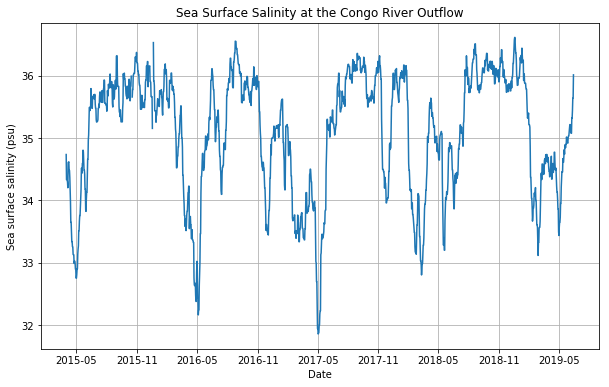

In [5]:
# First define our variables to plot.
xdata = xdata_time_series # time (days since reference time)
ydata = ydata_time_series # salinity (psu)

# Handle the time information.
reftime = dt.datetime(2000,1,1,0,0,0) # define reference time using "datetime" package
xtime = np.array([ reftime + dt.timedelta(days=xdata[ii]) for ii in range(len(xdata)) ])

plt.figure(figsize=(10,6))
plt.plot(xtime,ydata)
plt.xlabel("Date")
plt.ylabel("Sea surface salinity (psu)")
plt.title("Sea Surface Salinity at the Congo River Outflow")
plt.grid(True, which="both")
plt.savefig("timeseries.png",format='png',dpi=300)

### Just double-check if `imin` and `jmin` are the correct indices.

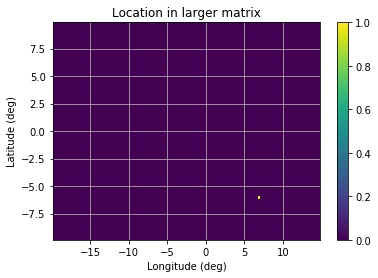

In [6]:

# Plot the location of interest.
dummy = np.zeros([nlats,nlons]) # all locations set to 0.0
dummy[imin,jmin] = 1 # location set to 1.0

plt.pcolor(lons,lats,(dummy))
#plt.clim(0,1)
plt.xlabel('Longitude (deg)')
plt.ylabel('Latitude (deg)')
plt.title('Location in larger matrix')
plt.grid()
plt.colorbar()
plt.show()

# Estimate the spectrum of this time series.

### Handle NaNs (or Not-a-Number) values. These are _**bad values**_ that we replace with _**good values.**_

First, we need to replace the bad values with good values. Here, we replace with **mean** values.

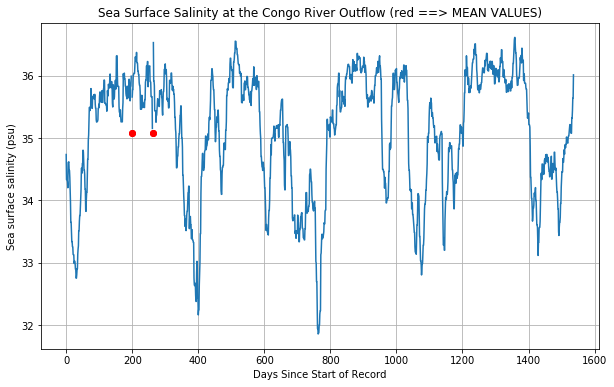

In [7]:
# Again, define the variable of interest and the time vector.
time = xdata_time_series - xdata_time_series[0] # time (days)
data = ydata_time_series # salinity (psu)

# Find nans in this time series.
inan = np.isnan(data)
tmp = np.zeros(data.shape,dtype=float)
tmp[inan] = 1.0

#======================================

# Replace bad values with better values. Here, we use the mean value.
time_new = np.copy(time) # make a copy of the time array
data_new = np.copy(data) # make a copy of the data array
mn_data = np.nanmean(data)
data_new[inan] = mn_data

# Set up plot.
plt.figure(figsize=(10,6))
plt.plot(time,data)
plt.plot(time_new[inan],data_new[inan],'o',color='red')
plt.xlabel("Days Since Start of Record")
plt.ylabel("Sea surface salinity (psu)")
plt.title("Sea Surface Salinity at the Congo River Outflow (red ==> MEAN VALUES)")
plt.grid(True, which="both")
plt.savefig("timeseries_meanvalues.png",format='png',dpi=300)

Another method is to replace the bad values with **interpolated** values.

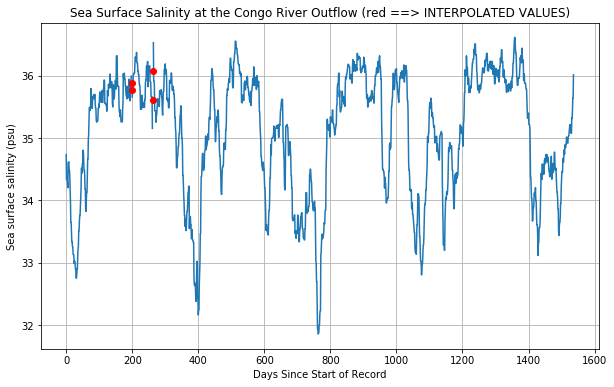

In [8]:
# Again, define the variable of interest and the time vector.
time = xdata_time_series - xdata_time_series[0] # time (days)
data = ydata_time_series # salinity (psu)

# Find nans in this time series.
inan = np.isnan(data)
tmp = np.zeros(data.shape,dtype=float)
tmp[inan] = 1.0
igood = np.where(tmp == 0) # locations of good data

# Replace bad values with better values.
# Here, we replace bad data with good data (interpolation).
time_new = np.copy(time) # make a copy of the time array
data_new = np.copy(data) # make a copy of the data array
data_new = np.interp(time_new,time[igood],data[igood])

# Set up plot.
plt.figure(figsize=(10,6))
plt.plot(time,data)
plt.plot(time_new[inan],data_new[inan],'o',color='red')
plt.xlabel("Days Since Start of Record")
plt.ylabel("Sea surface salinity (psu)")
plt.title("Sea Surface Salinity at the Congo River Outflow (red ==> INTERPOLATED VALUES)")
plt.grid(True, which="both")
plt.savefig('timeseries_interpolated.png',format='png',dpi=300)

This looks much better ... **Let's keep this time series for our analysis.**

## Estimate the spectrum of the time series.

Before starting, we determine the sampling interval or _**sampling period**_ for the data, `SamplingPeriod`. This is necessary for the function or routine (`signal.welch`) that estimates the spectrum. It also determines the highest frequency we can observe -- i.e. Fs/2, where `Fs = 1/SamplingPeriod` is called the _**sampling frequency**_.

In [9]:
# Define the sampling period of the data.
SamplingPeriod = np.mean(np.diff(time_new)) # sampling interval in meridional direction
print("The sampling interval in time is {}".format(SamplingPeriod) + " days")

The sampling interval in time is 1.0032658393207055 days


Next, we compute the spectra of the time series. The details of this computation are a bit beyond the time-line for this project, but here are some useful points:

- spectral estimation methods are generally grouped into two categories: **traditional (i.e. Fourier-based)** and **modern** spectral estimation. The former makes use of the Fast Fourier Transform (FFT), while the latter uses finite information about the covariance of the time seriers to *parameterise* the spectrum.
- the most common and more easily understood traditional spectral estimation method is called _**Welch's method of averaged, modified periodograms**_. (Periodogram is a technical term meaning the fast Fourier transform, or FFT, of a signal.) Essentially, the entire time series is broken up into $N$ segments each having length `nele`. The signals are multiplied by a **window** (e.g. a Gaussian or hamming window). The FFT of each of these signals is computed and the resulting spectra are averaged together. We refer to this estimate as the **power spectral density**.
- The purpose of the window is to reduce side-lobe energy that would otherwise occur. If the window were not applied, this is the same as multiplying an infinite time series by a box-car window. The result is a blurred spectrum and energy at frequencies which should not have energy. Scientists / engineers have spent their entire lifetimes examining which windows are best. See, for example, Harris (1978): *On the use of windows for ...* I personally find the `hamming` or `hanning` windows work just fine.
- when using traditional spectral estimation methods, one must chose the length of the segment to properly resolve the signal of interest. Longer lengths (i.e. `nele` very large) create finer resolution in time but result in poor estimates of the spectrum. Shorter lengths (i.e. `nele` very small) do not resolve large period signals but result in more accurate spectra.
- before computing the FFT it is generally a good idea to *detrend* the signal. Here, we remove a linear trend from the signal, which helps to reduce the (white) noise level of the spectrum.

Below, we use a single periodogram to calculate the spectrum. Since this corresponds to only one FFT, so the confidence on our estimate is pretty small. Nonetheless, it is possible to see the seasonal signal in the spectra.

In [21]:
npts_total = len(time_new)
kkstep = 0
iistep = 0

# Compute spectra.
Fs = (1/SamplingPeriod) # sampling frequency or wavenumber in inverse days
xdata = data_new # define input data
inan = np.isnan(xdata) # identify bad data
xdata[inan] = np.nan # set equal to nan for now
xmean = np.nanmean(xdata) # get mean without nans
xdata[inan] = xmean # subsitutde mean values
xdata = signal.detrend(xdata) # remove a linear trend

# The following will provide a spectrum using welch's method of averaged modified periodograms.
nele = 4*365 #np.floor(len(xdata)/5)
novr = np.round(nele/2)
print(xdata.shape)
print(xdata.dtype)
hwin = signal.get_window('hamming',nele) # create a hamming window of length "nele"
f, Pxx = signal.welch(xdata, fs=Fs, window=hwin, nperseg=len(hwin), noverlap=novr, \
                                      nfft=nele, detrend="linear", return_onesided="true", \
                                      scaling="density")

(1532,)
float64


Below, we plot the spectra as a function of frequency (i.e. inverse time). To help with interpretation, we add a red vertical line that corresponds to a frequency of $ f = 1/period = 1/(365)$ inverse days or a period of $ T = 365$ days.

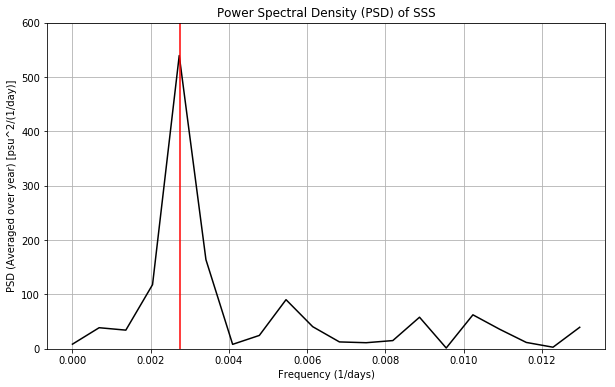

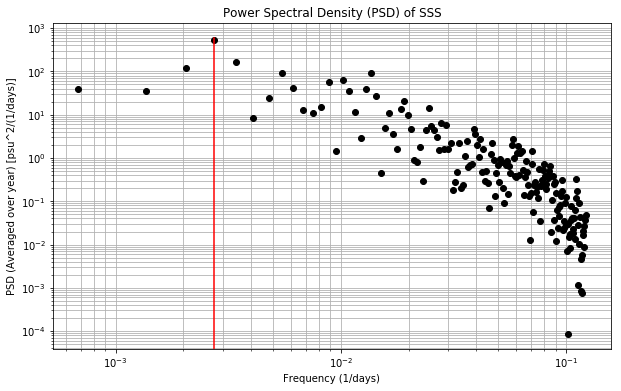

In [22]:
# Plot the spectrum in the usual coordinates.
T_seasonal = 365
f_seasonal = 1/T_seasonal

fig, ax = plt.subplots(1,1)

plt.plot(f[0:20],Pxx[0:20],'k-')
plt.plot(np.array([f_seasonal,f_seasonal]),np.array([0,600]),'r-')
plt.grid(True, which="both")
plt.xlabel("Frequency (1/days)")
plt.ylabel("PSD (Averaged over year) [psu^2/(1/day)]")
plt.rcParams['figure.figsize'] = (10, 6)
plt.ylim(0,600)
ax.set_title("Power Spectral Density (PSD) of SSS")
plt.savefig("spectrum_withannualsignal.png",format='png',dpi=300)

fig, ax = plt.subplots(1,1)

pc = ax.loglog(f[0:180],Pxx[0:180],'ko')
plt.plot(np.array([f_seasonal,f_seasonal]),np.array([0,600]),'r-')
plt.grid(True, which="both")
plt.xlabel("Frequency (1/days)")
plt.ylabel("PSD (Averaged over year) [psu^2/(1/days)]")
plt.rcParams['figure.figsize'] = (10, 6)
ax.set_title("Power Spectral Density (PSD) of SSS")
plt.savefig("spectrum_withannualsignal_logged.png",format='png',dpi=300)

<div class="alert alert-block alert-info">
        <b>A few notes on interpreting spectra:</b> It is worth understanding how to interpret spectra. Spectral plots show us how much energy or _*power*_ is contained in waves of a given frequency. **Indeed, if one integrates the spectra and subtracts the square of the value shown at $f = 0$ (i.e. the square of the mean value), one should obtain the variance of the original time series. In this case, we obtain the variance of sea surface salinity (SSS).** On the left side of the plot, we see the power spectral density (PSD) of long-period waves. On the right side of the plot, we see the PSD of short-period waves.
</div>

<div class="alert alert-block alert-info">
        <b>Additional notes on the minimum and maximum signals resolved:</b> 
The largest period resolved by the FFT algorithm is equal to `nele*SamplingPeriod`, where `nele` is given above. Since `SamplingPeriod` is one day for our dataset, we have a maximum-resolved period of `nele*SamplingPeriod` = $4*365 = 1460$ days (or 4 years). Also, since the period is equal to 1/frequency, this corresponds to a minimum frequency of $f_{min} = 1/T = 1/(1460$ d$) = 0.000685$ d$^{-1}$. Also of note, the maximum frequency one can resolve is $f_{max} = Fs/2$, where $Fs$ is the sampling period. This therefore corresponds to resolving signals with periods no smaller than `2*SamplingPeriod`, or 2 days.
</div>

Note that the spectra above looks noisy, particularly for high-frequency (short period) waves. One way we can improve our signal quality is by reducing our segment length (i.e. reducing `nele`). This corresponds to averaging more spectra together.

In [23]:
# Compute power spectral density.

npts_total = len(time_new)
kkstep = 0
iistep = 0

# Compute spectra.
Fs = (1/SamplingPeriod) # sampling frequency or wavenumber in inverse days
xdata = data_new # define input data
inan = np.isnan(xdata) # identify bad data
xdata[inan] = np.nan # set equal to nan for now
xmean = np.nanmean(xdata) # get mean without nans
xdata[inan] = xmean # subsitutde mean values
xdata = signal.detrend(xdata) # remove a linear trend

# The following will provide a spectrum using welch's method of averaged modified periodograms.
nele = 180 #np.floor(len(xdata)/5)
novr = np.round(nele/2)
print(xdata.shape)
print(xdata.dtype)
hwin = signal.get_window('hamming',nele) # create a hamming window of length "nele"
f, Pxx = signal.welch(xdata, fs=Fs, window=hwin, nperseg=len(hwin), noverlap=novr, \
                                      nfft=nele, detrend="linear", return_onesided="true", \
                                      scaling="density")

(1532,)
float64


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


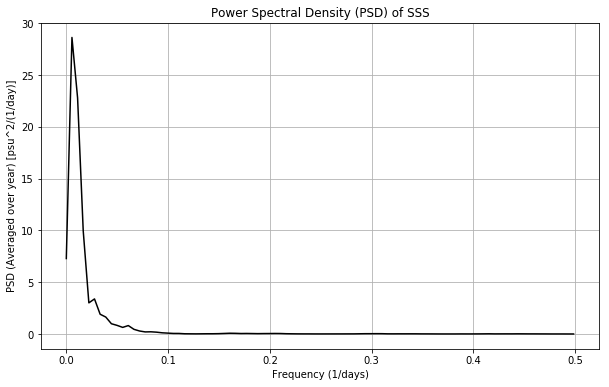

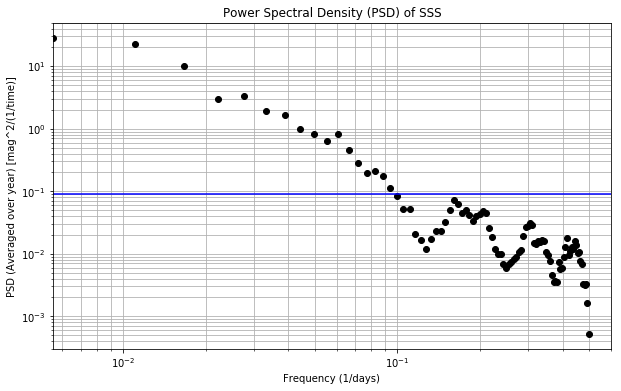

In [24]:
# Plot the spectrum in loglog coordinates.
fig, ax = plt.subplots(1,1)

plt.plot(f[0:180],Pxx[0:180],'k-')
plt.grid(True, which="both")
plt.xlabel("Frequency (1/days)")
plt.ylabel("PSD (Averaged over year) [psu^2/(1/day)]")
plt.rcParams['figure.figsize'] = (10, 6)
plt.title("Power Spectral Density (PSD) of SSS")
plt.savefig("spectrum_withannualsignal_multipleFFT.png",format='png',dpi=300)

fig, ax = plt.subplots(1,1)

pc = ax.loglog(f[0:180],Pxx[0:180],'ko')
plt.plot(np.array([0,6e-1]),np.array([0.09,0.09]),'b-')
plt.grid(True, which="both")
plt.xlabel("Frequency (1/days)")
plt.ylabel("PSD (Averaged over year) [mag^2/(1/time)]")
plt.rcParams['figure.figsize'] = (10, 6)
plt.xlim([0,6e-1])
ax.set_title("Power Spectral Density (PSD) of SSS")
plt.savefig("spectrum_withannualsignal_logged_multipleFFT.png",format='png',dpi=300)

The peaks in the spectrum at frequencies higher than 0.1 days$^{-1}$ are likely the result of the satellite passing over the location infrequently and errors introduced during mapping of the data to the one-day grid. (Recall: the data are daily in temporal resolution but each data point is an 8-day moving average.) Thus, we refer to the amplitude of this noise as the **noise level** of our dataset. Here, we illustrate this by a horizontal blue line.

### EXTRA CHALLENGE

For an added challenge, one could download sea surface temperature (SST) from the same website -- i.e. Remote Sensing Systems (http://www.remss.com/) -- and perform all of the same analysis. This would require modifying the Lessons 1, 2, and 3 to construct different filenames, read different NetCDF data, make sure units were correct, and changing the filenames saved to file (when making the movie). A challenge, yes, but do-able given your skill set.

**Please let us know if you succeed in reading in the SST dataset: christian.buckingham@univ-brest.fr**